In [47]:
import pandas as pd
import numpy as np
import os
import glob
import datetime

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import tensorflow

# from tensorflow.compat.v1.keras.backend import get_session
# tensorflow.compat.v1.disable_v2_behavior()
# import shap

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout
from sklearn import preprocessing

import tensorflow as tf

import numpy as np
import os
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
from os.path import isfile, join
from sys import getsizeof
import glob

from random import *

import matplotlib.pyplot as plt
# plt.ion()
%matplotlib widget

#import mpld3
#mpld3.enable_notebook()
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

/home/jackalak/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


# Only using years 2010, 2011, 2012, 2013, and 2014 because of the auroral boundary database used only has those dates

In [48]:
file_load_df_cumulative = '../ParticlePrecipitation/ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine.csv'
DMSP_DATA_DIR=''
df_cumulative = pd.read_csv(os.path.join(DMSP_DATA_DIR,file_load_df_cumulative))
df_cumulative = df_cumulative.sort_values(by=['ID_SC', 'Datetimes'])
df_cumulative = df_cumulative.set_index('Datetimes')
df_cumulative.index = pd.to_datetime(df_cumulative.index)

cols_to_drop_validation = [c for c in df_cumulative.columns if ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
# cols_to_drop_validation = [c for c in df.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('5min' in c) | ('15min' in c) | ('newell' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]

df_cumulative = df_cumulative.drop(columns=cols_to_drop_validation)

# Separate training and testing data
mask_val = [(df_cumulative.index.year == 2010) & (df_cumulative['ID_SC'].values==16)]
df_val = df_cumulative[mask_val[0]].copy(deep=True)
df_train = df_cumulative.copy(deep=True).drop( df_cumulative.index[mask_val[0]])

mask_for_2010_to_2014 = [(df_train.index.year == 2010) | (df_train.index.year == 2011)
                         | (df_train.index.year == 2012) |(df_train.index.year == 2013)
                         | (df_train.index.year == 2014)]
df_train = df_train[mask_for_2010_to_2014[0]]
df_train = df_train.sort_values(by=['ID_SC', 'Datetimes'])
df_val = df_val.sort_values(by=['ID_SC', 'Datetimes'])

In [49]:
# Construct X and y
feature_cols = [c for c in df_train.columns if not 'ELE' in c]
#print( (feature_cols))
#print(df_cumulative.columns)
X_val = df_val[feature_cols].copy(deep=True)
y_val = df_val['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
y_train = df_train['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))
X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)

# First train without considering the auroral regions at all to get a baseline MSE accuracy

In [4]:
%matplotlib widget
plt.figure()
# summarize history for loss
plt.hist(y_val_log.values)
plt.show()

plt.figure()
# summarize history for loss
plt.hist(y_train_log.values)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [5]:
# model = Sequential()

# model.add(Dense(int(256), activation='relu'))
# model.add(Dropout(.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(1))


# #compile model using accuracy to measure model performance
# model.compile(loss='mse', optimizer='adam',  metrics=['mse'])

# history = model.fit(X, np.array(y_train_log), validation_data=(X_test, np.array(y_val_log)),
#                     batch_size=1024,epochs=1000)

# plt.figure()
# # summarize history for loss
# plt.plot(history.history['val_loss'][200:])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [6]:

filename = 'best_base_line'

# model.save(filename)
model = tensorflow.keras.models.load_model(filename)

results = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)

df_results = pd.DataFrame(data=results, index = X_val.index)

plt.figure()
plt.plot(y_val_log[:500])
plt.plot(df_results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y_val_log[:5000])
plt.plot(df_results[:5000])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y_val_log[:])
plt.plot(df_results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y_val_log[-500:])
plt.plot(df_results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y_val_log[:])
plt.plot(df_results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y_val_log[-500:])
plt.plot(df_results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:
plt.figure()
plt.plot(y_val_log[35:80])
plt.plot(df_results[35:80])
plt.legend(['true energy flux', 'predicted energy flux'], loc='upper left')
plt.title('With out Auroral boundary estimator input')
plt.show()

plt.figure()
plt.plot(X_val['SC_AACGM_LAT'][35:80])
plt.legend(['MLat'], loc='upper left')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Read in the the auroral regions from a pickle file (constructed from auroral boundary transition points) 

In [50]:

df_val = pd.read_pickle("./with_aurora_type_val.pkl")
df_train = pd.read_pickle("./with_aurora_type_train.pkl")


In [9]:
sum(df_val['aurora_type']==5)/df_val['aurora_type'].shape[0]

0.564933888788263

In [10]:
sum(df_train['aurora_type']==5)/df_train['aurora_type'].shape[0]

0.5490338676186004

# The boundary transition type regions can be reduced to 3 instead of 4 regions (plus unknown region 5), because going into the auroal region from the equatorial region or the polar region is the same for our intention of labeling just equatorial region, auroral, region, or polar region. 

# therefore type 4 is the same as type 1

In [51]:
df_val['aurora_type'][ df_val['aurora_type']==4 ]= 1
df_train['aurora_type'][ df_train['aurora_type']==4 ]= 1

print('equatorial', sum(df_train['aurora_type']==2)/df_train['aurora_type'].shape[0])
print('auroral', sum(df_train['aurora_type']==1)/df_train['aurora_type'].shape[0])
print('polar', sum(df_train['aurora_type']==3)/df_train['aurora_type'].shape[0])
print('unknown', sum(df_val['aurora_type']==5)/df_val['aurora_type'].shape[0])

equatorial 0.22883672092633456
auroral 0.10463513594006918
polar 0.11624617848203142
unknown 0.564933888788263


In [52]:

mask = ( np.isnan(df_train['aurora_type'])==False )
df_train_clean = df_train[mask].copy(deep=True)
mask = ( np.isnan(df_val['aurora_type'])==False)
df_val_clean = df_val[mask].copy(deep=True)

In [53]:

# Construct X and y
feature_cols = [c for c in df_train_clean.columns if not 'ELE' in c]
#print( (feature_cols))
#print(df_cumulative.columns)
X_val = df_val_clean[feature_cols].copy(deep=True)
y_val = df_val_clean['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train_clean[feature_cols].copy(deep=True)
y_train = df_train_clean['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))

X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)

Y = np.array(y_train_log, dtype=np.float32)


In [14]:
X_train_no_aurora_type = X_train.drop(columns='aurora_type')
X_val_no_aurora_type = X_val.drop(columns='aurora_type')
scaler_X = scaler_X.fit(X_train_no_aurora_type.values)
X_val_no_aurora_type_scaled = scaler_X.transform(X_val_no_aurora_type.values)
X_train_no_aurora_type_scaled = scaler_X.transform(X_train_no_aurora_type.values)

y_train_aurora_type = X_train['aurora_type']
y_val_aurora_type = X_val['aurora_type']

In [54]:

label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

integer_encoded = label_encoder.fit_transform(y_train_aurora_type)
print(integer_encoded.shape)

integer_encoded_train = integer_encoded.reshape(len(integer_encoded), 1)
print(integer_encoded.shape)

y_train_aurora_type_encoded = onehot_encoder.fit_transform(integer_encoded_train)
integer_encoded = label_encoder.fit_transform(y_val_aurora_type)
integer_encoded_val = integer_encoded.reshape(len(integer_encoded), 1)
y_val_aurora_type_encoded = onehot_encoder.fit_transform(integer_encoded_val)

print(X_train_no_aurora_type_scaled.shape)

print(y_train_aurora_type.shape)
print(y_train_aurora_type_encoded.shape)

(324651,)
(324651,)
(324651, 148)
(324651,)
(324651, 3)


In [55]:

mask = [ (np.isnan(df_train['aurora_type'])==False) & (df_train['aurora_type'] != 5 ) ]
df_train_clean = df_train[mask[0]].copy(deep=True)
print((mask[0].any())==False)
mask = [ (np.isnan(df_val['aurora_type'])==False) & (df_val['aurora_type'] != 5 ) ]
df_val_clean = df_val[mask[0]].copy(deep=True)



# Construct X and y
feature_cols = [c for c in df_train_clean.columns if not 'ELE' in c]
from sklearn import preprocessing
X_val = df_val_clean[feature_cols].copy(deep=True)
y_val = df_val_clean['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train_clean[feature_cols].copy(deep=True)
y_train = df_train_clean['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))


X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)

Y = np.array(y_train_log, dtype=np.float32)

X_train_no_aurora_type = X_train.drop(columns='aurora_type')
X_val_no_aurora_type = X_val.drop(columns='aurora_type')
scaler_X = scaler_X.fit(X_train_no_aurora_type.values)
X_val_no_aurora_type_scaled = scaler_X.transform(X_val_no_aurora_type.values)
print(X_val_no_aurora_type_scaled.shape)
X_train_no_aurora_type_scaled = scaler_X.transform(X_train_no_aurora_type.values)

y_train_aurora_type = X_train['aurora_type']
y_val_aurora_type = X_val['aurora_type']

label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

integer_encoded = label_encoder.fit_transform(y_train_aurora_type)
print(integer_encoded.shape)

integer_encoded_train = integer_encoded.reshape(len(integer_encoded), 1)
print(integer_encoded.shape)

y_train_aurora_type_encoded = onehot_encoder.fit_transform(integer_encoded_train)
integer_encoded = label_encoder.fit_transform(y_val_aurora_type)
integer_encoded_val = integer_encoded.reshape(len(integer_encoded), 1)
y_val_aurora_type_encoded = onehot_encoder.fit_transform(integer_encoded_val)

print(X_train_no_aurora_type_scaled.shape)

print(y_train_aurora_type.shape)
print(y_train_aurora_type_encoded.shape)

sum(df_val_clean['aurora_type']==2)/df_val_clean.shape[0]
sum(df_train_clean['aurora_type']==2)/df_train_clean.shape[0]

print('equatorial', sum(df_train['aurora_type']==2)/df_train['aurora_type'].shape[0])
print('auroral', sum(df_train['aurora_type']==1)/df_train['aurora_type'].shape[0])
print('polar', sum(df_train['aurora_type']==3)/df_train['aurora_type'].shape[0])

plt.hist(y_val_aurora_type)
plt.show()
plt.hist(y_train_aurora_type)
plt.show()

False
(23848, 148)
(324651,)
(324651,)
(324651, 148)
(324651,)
(324651, 3)
equatorial 0.22883672092633456
auroral 0.10463513594006918
polar 0.11624617848203142


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [17]:
# model = Sequential()

# model.add(Dense(int(256), activation='relu'))
# model.add(Dropout(.5))

# model.add(Dense(64, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(3,activation='softmax'))

# #compile model using accuracy to measure model performance
# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer='adam',  metrics=['accuracy'])

# history = model.fit(X_train_no_aurora_type_scaled, y_train_aurora_type_encoded, validation_data=(X_val_no_aurora_type_scaled, y_val_aurora_type_encoded), batch_size=32,epochs=75)

In [18]:
# filename = 'best_auroral_region_predictor'

# # model = tensorflow.keras.models.load_model(filename)
# model.save(filename)
# model.save_weights('best_auroral_region_predictor_weights.h5')

In [19]:
filename = 'best_auroral_region_predictor'

model = tensorflow.keras.models.load_model(filename)
# model.save(filename)
# model.save_weights('best_auroral_region_predictor_weights.h5')

model.evaluate(X_val_no_aurora_type_scaled, y_val_aurora_type_encoded)

results = (model.predict_classes(X_val_no_aurora_type_scaled))#, y_val_log.values)#, batch_size=128)

df_results = pd.DataFrame(data=results, index = X_val.index)
val = pd.DataFrame(data=integer_encoded_val, index = X_val.index)
# plt.figure()

# plt.plot( integer_encoded_val[:3000])
# plt.plot(results[:3000])
# plt.show()
plt.figure()

plt.plot( val[:100])
plt.plot(df_results[:100])
plt.show()

plt.figure()

plt.plot( val[:500])
plt.plot(df_results[:500])
plt.show()

746/746 [==============================] - 1s 1ms/step - loss: 0.1872 - accuracy: 0.9190


W0720 20:16:58.139238 139775792006976 deprecation.py:323] From <ipython-input-19-517d4edcdd71>:9: Sequential.predict_classes (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Now use this Auroal region predictor model to predict what type the "unknown/unspecified" regions are.  Then combine this predicted data with the known training and test data

In [56]:
 
mask = [ (np.isnan(df_train['aurora_type'])==True) | (df_train['aurora_type'] == 5 ) ]
df_train_pred = df_train[mask[0]].copy(deep=True)
print((mask[0].any())==False)
mask = [ (np.isnan(df_val['aurora_type'])==True) | (df_val['aurora_type'] == 5 ) ]
df_val_pred = df_val[mask[0]].copy(deep=True)
print(df_train_pred.shape)
print(df_val_pred.shape)

False
(397248, 150)
(31362, 150)


In [57]:
# Construct X and y
feature_cols = [c for c in df_train_pred.columns if (not ( 'ELE' in c) | ('aurora_type' in c))]
X_train = df_train_pred[feature_cols].copy(deep=True)
X_val = df_val_pred[feature_cols].copy(deep=True)
print(X_train.shape)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)
X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)
#scaler_X = scaler_X.fit(X_train_no_aurora_type.values)



(397248, 148)


In [58]:

print(X.shape)

print((model.predict_classes(X_train_no_aurora_type_scaled)).shape)
print(df_train_pred.shape)

df_train_pred['aurora_type']= model.predict_classes(X)+1
df_val_pred['aurora_type']= model.predict_classes(X_test)+1

plt.figure()
plt.hist(df_train_pred['aurora_type'])
plt.figure()
plt.hist(df_train_clean['aurora_type'])

print(df_train_pred.shape)
print(df_train_clean.shape)

frames = [df_train_clean, df_train_pred]
df_train_new = pd.concat(frames)
frames = [df_val_clean, df_val_pred]
df_val_new = pd.concat(frames) 

print(df_val_new.values.shape)

(397248, 148)


ValueError: in user code:

    /home/jackalak/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    /home/jackalak/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/jackalak/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/jackalak/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/jackalak/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1122 predict_step  **
        return self(x, training=False)
    /home/jackalak/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /home/jackalak/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected axis -1 of input shape to have value 149 but received input with shape [None, 148]


In [60]:

# Construct X and y
feature_cols = [c for c in df_train_new.columns if not 'ELE' in c]

X_val = df_val_new[feature_cols].copy(deep=True)
y_val = df_val_new['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train_new[feature_cols].copy(deep=True)
y_train = df_train_new['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))

X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)


In [61]:
sample_weights = np.ones((X_train.values.shape[0]))
for i in range(0,X_train.values.shape[0]):
    if X_train['aurora_type'].values[i]==1:
        sample_weights[i]=10

plt.figure()
plt.hist(sample_weights)
plt.figure()
plt.hist(X_train['aurora_type'].values)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(array([174354.,      0.,      0.,      0.,      0., 362529.,      0.,
             0.,      0., 185016.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

# Now with the supervised auroral type values and the predicted (unsupervised) type values as a new column in the input X, predict the scalar energy flux y

In [25]:
# model = Sequential()

# model.add(Dense(int(256), activation='relu'))
# model.add(Dropout(.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(1))


# #compile model using accuracy to measure model performance
# model.compile(loss='mse', optimizer='adam',  metrics=['mse','mae'])

# history = model.fit(X, np.array(y_train_log), 
#     validation_data=(X_test, np.array(y_val_log)), batch_size=1024,epochs=1000, sample_weight=sample_weights)

In [26]:
filename = 'best_with_auroral_region_weights'

# model.save(filename)

model = tensorflow.keras.models.load_model(filename)
#model.save_weights('my_model_weights.h5')


# print(history.history.keys())
# plt.figure()
# # summarize history for loss
# plt.plot(history.history['loss'][20:])
# plt.plot(history.history['val_loss'][20:])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# plt.figure()
# # summarize history for loss
# plt.plot(history.history['loss'][20:])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# plt.figure()
# # summarize history for loss
# plt.plot(history.history['val_loss'][20:])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# plt.figure()
# # summarize history for loss
# plt.plot(history.history['val_loss'][200:])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [27]:
model.evaluate(X_val_scaled,y_val_log)


1726/1726 [==============================] - 2s 980us/step - loss: 0.5924 - mean_squared_error: 0.5924 - mean_absolute_error: 0.5501


[0.592354953289032, 0.592354953289032, 0.5500954389572144]

In [28]:
results = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)

df_results = pd.DataFrame(data=results, index = X_val.index)

plt.figure()
plt.plot(y_val_log[:500])
plt.plot(df_results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y_val_log[:5000])
plt.plot(df_results[:5000])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y_val_log[:])
plt.plot(df_results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y_val_log[-500:])
plt.plot(df_results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y_val_log[:])
plt.plot(df_results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y_val_log[-500:])
plt.plot(df_results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [64]:
filename = 'best_with_auroral_region_weights'
model = tensorflow.keras.models.load_model(filename)
results = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)
df_results = pd.DataFrame(data=results, index = X_val.index)

indices = np.array(np.linspace(35,80,num=80-35+1,dtype=np.int))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('flux', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1.plot(y_val_log[:5000])
ax1.plot(df_results[:5000])


filename = 'best_base_line'
model = tensorflow.keras.models.load_model(filename)
results = model.predict(X_val_scaled[:,:148])#, y_val_log.values)#, batch_size=128)
df_results = pd.DataFrame(data=results, index = X_val.index)

ax1.plot(df_results[:5000])

ax1.legend(['true energy flux', 'predicted with auroral region', 'predicted  baseline'], loc='lower left')
plt.title('Weighted samples')
plt.show()


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:purple'
ax2.set_ylabel('MLat', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(X_val['SC_AACGM_LAT'][:5000], color=color)
ax1.legend(['true energy flux', 'predicted with auroral region', 'predicted  baseline'], loc='lower left')


fig.tight_layout()  # otherwise the right y-label is slightly clipped


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Now with the supervised auroral type values and the predicted (unsupervised) type values as a new column in the input X, predict the scalar energy flux y

# The target Y is now a vector result where the true value only has one of the three as non-zero, the correct answer is specified by the auroral region type, equatorial region, in aurora, and the polar region

# The loss is the MSE of all three, to compare this loss to the previous approach that is signal modal, multiply the loss by the number of modes which is three

In [69]:

# Construct X and y
feature_cols = [c for c in df_train_new.columns if not 'ELE' in c]
X_val = df_val_new[feature_cols].copy(deep=True)
y_val = df_val_new['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train_new[feature_cols].copy(deep=True)
y_train_val = df_train_new['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log1 = np.log10(y_train.copy(deep=True))
y_val_log1 = np.log10(y_val.copy(deep=True))

y_train_log = np.zeros((y_train_log1.values.shape[0],3))
y_val_log = np.zeros((y_val_log1.values.shape[0],3))

for i in range(0,X_val.values.shape[0]):
    if X_val['aurora_type'].values[i] == 1:
        y_val_log[i,0]=y_val_log1.values[i]
    if X_val['aurora_type'].values[i] == 2:
        y_val_log[i,1]=y_val_log1.values[i]
    if X_val['aurora_type'].values[i] == 3:
        y_val_log[i,2]=y_val_log1.values[i]
for i in range(0,X_train.values.shape[0]):
    if X_train['aurora_type'].values[i] == 1:
        y_train_log[i,0]=y_train_log1.values[i]
    if X_train['aurora_type'].values[i] == 2:
        y_train_log[i,1]=y_train_log1.values[i]
    if X_train['aurora_type'].values[i] == 3:
        y_train_log[i,2]=y_train_log1.values[i]



scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)

plt.figure()
plt.hist(X_val['aurora_type'].values)
plt.figure()
plt.hist(X_train['aurora_type'].values)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(array([174354.,      0.,      0.,      0.,      0., 362529.,      0.,
             0.,      0., 185016.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

In [70]:
# model = Sequential()

# model.add(Dense(int(256), activation='relu'))
# model.add(Dropout(.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(3))


# #compile model using accuracy to measure model performance
# model.compile(loss='mse', optimizer='adam',  metrics=['mse'])

# history = model.fit(X, np.array(y_train_log), 
#                     validation_data=(X_test, np.array(y_val_log)), batch_size=1024,epochs=1000, sample_weight=sample_weights)

In [71]:
# filename = 'best_with_auroral_region4_weighted'

# model.save(filename)
# # model.save_weights('my_model_weights2.h5')

In [72]:
filename = 'best_with_auroral_region4_weighted'

model = tensorflow.keras.models.load_model(filename)

model.evaluate(X_val_scaled,np.array(y_val_log))


# print(history.history.keys())
# plt.figure()
# # summarize history for loss
# plt.plot(history.history['loss'][20:])
# plt.plot(history.history['val_loss'][20:])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# plt.figure()
# # summarize history for loss
# plt.plot(history.history['loss'][20:])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# plt.figure()
# # summarize history for loss
# plt.plot(history.history['val_loss'][20:])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# plt.figure()
# # summarize history for loss
# plt.plot(history.history['val_loss'][200:])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

1726/1726 [==============================] - 1s 807us/step - loss: 0.1963 - mean_squared_error: 0.1963


[0.19632026553153992, 0.19632026553153992]

In [73]:
results1 = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)
print(results1.shape[0])
results = np.zeros((results1.shape[0]))
y = np.zeros((results1.shape[0]))
print(y.shape)
for i in range(0,results1.shape[0]):
    results[i]= np.max(results1[i,:])
    y[i] = np.max(y_val_log[i,:])
    
df_results = pd.DataFrame(data=results, index = X_val.index)
y = pd.DataFrame(data=y, index = X_val.index)

plt.figure()
plt.plot(y[:500])
plt.plot(df_results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y[:5000])
plt.plot(df_results[:5000])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y[:])
plt.plot(df_results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y[-500:])
plt.plot(df_results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

55210
(55210,)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [74]:
mse_final = np.average((df_results.values-y.values)**2)
print(mse_final)

0.587224906448618


In [75]:


results1 = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)
print(results1.shape[0])
results = np.zeros((results1.shape[0]))
y = np.zeros((results1.shape[0]))
print(y.shape)
for i in range(0,results1.shape[0]):
    results[i]= np.sum(results1[i,:])
    y[i] = np.sum(y_val_log[i,:])
    
df_results = pd.DataFrame(data=results, index = X_val.index)
y = pd.DataFrame(data=y, index = X_val.index)

plt.figure()
plt.plot(y[:500])
plt.plot(df_results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y[:5000])
plt.plot(df_results[:5000])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y[:])
plt.plot(df_results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y[-500:])
plt.plot(df_results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

mse_final = np.average((df_results.values-y.values)**2)
print(mse_final)

55210
(55210,)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0.5877706938945003


# Now try as an autual run senario where auroral type column is fully predicted

In [76]:
df_val = pd.read_pickle("./with_aurora_type_val.pkl")
df_train = pd.read_pickle("./with_aurora_type_train.pkl")

df_val['aurora_type'][ df_val['aurora_type']==4 ]= 1
df_train['aurora_type'][ df_train['aurora_type']==4 ]= 1

filename = 'best_auroral_region_predictor'

model2 = tensorflow.keras.models.load_model(filename)

feature_cols = [c for c in df_train.columns if not 'ELE' in c]
X_val = df_val[feature_cols].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
X_train_no_aurora_type = X_train.drop(columns='aurora_type')
X_val_no_aurora_type = X_val.drop(columns='aurora_type')
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train_no_aurora_type.values)
X_val_scaled = scaler_X.transform(X_val_no_aurora_type.values)

results = (model2.predict_classes(X_val_scaled))+1
print(results.shape, X_val.shape)

plt.figure()
plt.plot(results[:500])
plt.plot(df_val['aurora_type'].values[:500])
plt.show()

feature_cols = [c for c in df_train.columns if not 'ELE' in c]
X_val = df_val[feature_cols].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)

X_val_real_senario = X_val.copy(deep=True)
X_val_real_senario['aurora_type'] = results

print(X_val_real_senario.shape)
X_val_real_senario_scaled = scaler_X.transform(X_val_real_senario.values)

(55210,) (55210, 149)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(55210, 149)


In [77]:
filename = 'best_with_auroral_region4_weighted'
model = tensorflow.keras.models.load_model(filename)

model.evaluate(X_val_scaled,y_val_log)
model.evaluate(X_val_real_senario_scaled,y_val_log)


results1 = model.predict(X_val_real_senario_scaled)#, y_val_log.values)#, batch_size=128)
print(results1.shape[0])
results = np.zeros((results1.shape[0]))
y = np.zeros((results1.shape[0]))
print(y.shape)
for i in range(0,results1.shape[0]):
    results[i]= np.sum(results1[i,:])
    y[i] = np.sum(y_val_log[i,:])
    
df_results = pd.DataFrame(data=results, index = X_val.index)
y = pd.DataFrame(data=y, index = X_val.index)

plt.figure()
plt.plot(y[:500])
plt.plot(df_results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y[:5000])
plt.plot(df_results[:5000])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y[:])
plt.plot(df_results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y[-500:])
plt.plot(df_results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

mse_final = np.average((df_results.values-y.values)**2)
print(mse_final)

1726/1726 [==============================] - 1s 845us/step - loss: 36.9522 - mean_squared_error: 36.9522
55210
(55210,)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

4.287133536640046


In [78]:
# This is without the vector output

filename = 'best_with_auroral_region_weights'
model = tensorflow.keras.models.load_model(filename)

model.evaluate(X_val_scaled,y.values)
model.evaluate(X_val_real_senario_scaled,y.values)


results = model.predict(X_val_real_senario_scaled)#, y_val_log.values)#, batch_size=128)

    
df_results = pd.DataFrame(data=results, index = X_val.index)

plt.figure()
plt.plot(y[:500])
plt.plot(df_results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y[:5000])
plt.plot(df_results[:5000])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y[:])
plt.plot(df_results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y[-500:])
plt.plot(df_results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()


1726/1726 [==============================] - 2s 942us/step - loss: 4.5414 - mean_squared_error: 4.5414 - mean_absolute_error: 1.7048


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [81]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('flux', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1.plot(y[:5000])
ax1.plot(df_results[:5000])


filename = 'best_base_line'
model = tensorflow.keras.models.load_model(filename)
results_baseline = model.predict(X_val_scaled[:,:148])#, y_val_log.values)#, batch_size=128)
df_results_baseline = pd.DataFrame(data=results_baseline, index = X_val.index)

ax1.plot(df_results_baseline[:5000])

ax1.legend(['true energy flux', 'predicted with auroral region', 'predicted  baseline'], loc='lower left')
plt.title('Weighted samples')
plt.show()


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:purple'
ax2.set_ylabel('MLat', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(X_val['SC_AACGM_LAT'][:5000], color=color)
ax1.legend(['true energy flux', 'predicted with auroral region', 'predicted  baseline'], loc='lower left')


fig.tight_layout()  # otherwise the right y-label is slightly clipped


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Trying Multi-modal without auroral region type as input for X (This is working)
(but still using the auroal type to specify y_train and y_val for which of the three modes it is in)

In [40]:
feature_cols = [c for c in X_val.columns if not 'aurora_type' in c]
X_val = X_val[feature_cols].copy(deep=True)
X_train = X_train[feature_cols].copy(deep=True)

scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)


In [41]:
# model = Sequential()

# model.add(Dense(int(256), activation='relu'))
# model.add(Dropout(.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(3))


# #compile model using accuracy to measure model performance
# model.compile(loss='mse', optimizer='adam',  metrics=['mse'])

# history = model.fit(X, np.array(y_train_log),
#                     validation_data=(X_test, np.array(y_val_log)), batch_size=1024,epochs=1000, sample_weight=sample_weights)

In [42]:
filename = 'best_modal__weighted'

# model.save(filename)
# model.save_weights('my_model_weights2.h5')

model = tensorflow.keras.models.load_model(filename)

model.evaluate(X_test,y_val_log)

results1 = model.predict(X_test)#, y_val_log.values)#, batch_size=128)
print(results1.shape[0])
results = np.zeros((results1.shape[0]))
y = np.zeros((results1.shape[0]))
print(y.shape)
for i in range(0,results1.shape[0]):
    results[i]= np.max(results1[i,:])
    y[i] = np.max(y_val_log[i,:])

df_results = pd.DataFrame(data=results, index = X_val.index)
y = pd.DataFrame(data=y, index = X_val.index)

plt.figure()
plt.plot(y[-500:])
plt.plot(df_results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()   


mse_final = np.average((df_results.values-y.values)**2)
print(mse_final)

1726/1726 [==============================] - 1s 825us/step - loss: 33.8009 - mean_squared_error: 33.8009
55210
(55210,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

4.5460274193608345


In [44]:

results1 = model.predict(X_test)#, y_val_log.values)#, batch_size=128)
print(results1.shape[0])
results = np.zeros((results1.shape[0]))
y = np.zeros((results1.shape[0]))
print(y.shape)
for i in range(0,results1.shape[0]):
    results[i]= np.sum(results1[i,:])
    y[i] = np.sum(y_val_log[i,:])

    
df_results = pd.DataFrame(data=results, index = X_val.index)
y = pd.DataFrame(data=y, index = X_val.index)

plt.figure()
plt.plot(y[-500:])
plt.plot(df_results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()   

mse_final = np.average((df_results.values-y.values)**2)
print(mse_final)


55210
(55210,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

3.9261112393614046


In [45]:
# history = model.fit(X, np.array(y_train_log), validation_data=(X_test, np.array(y_val_log)), batch_size=1024,epochs=1000)

# now test one of the models at one time for the whole earth

0 SC_AACGM_LAT
1 ID_SC
2 sin_ut
3 cos_ut
4 sin_doy
5 cos_doy
6 sin_SC_AACGM_LTIME
7 cos_SC_AACGM_LTIME
8 F107
9 Bz
10 By
11 Bx
(100, 100, 149)
[[ 9.00000000e+01  1.60000000e+01  5.94822787e-01 -8.03856861e-01
   5.16196672e-02  9.98666816e-01  3.71662157e-01  9.28368053e-01]
 [ 9.00000000e+01  1.60000000e+01  5.94822787e-01 -8.03856861e-01
   5.16196672e-02  9.98666816e-01  4.29794573e-01  9.02926700e-01]]


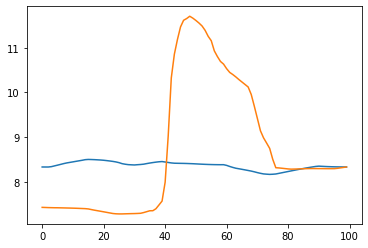

In [98]:
df_val = pd.read_pickle("./with_aurora_type_val.pkl")
df_train = pd.read_pickle("./with_aurora_type_train.pkl")

df_val['aurora_type'][ df_val['aurora_type']==4 ]= 1
df_train['aurora_type'][ df_train['aurora_type']==4 ]= 1

filename = 'best_auroral_region_predictor'

model2 = tensorflow.keras.models.load_model(filename)

feature_cols = [c for c in df_train.columns if not 'ELE' in c]
for i in range(0,12):
    print(i, feature_cols[i])
    
X_val = df_val[feature_cols].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
X_train_no_aurora_type = X_train.drop(columns='aurora_type')
scaler_X_region = preprocessing.RobustScaler()
scaler_X_region = scaler_X_region.fit(X_train_no_aurora_type.values)
# X_val_scaled = scaler_X_region.transform(X_val_no_aurora_type.values)

X_train = df_train[feature_cols].copy(deep=True)
scaler_X_all = preprocessing.RobustScaler()
scaler_X_all = scaler_X_all.fit(X_train.values)


mlatgridN = np.linspace(45,90,num=100)
mltgridN =  np.linspace(0,24,num=100)

test_i = 400
model_input = np.zeros((mlatgridN.shape[0], mltgridN.shape[0],149))
flux = np.zeros((mlatgridN.shape[0], mltgridN.shape[0]))
print(model_input.shape)
for i in range(0,mlatgridN.shape[0]):
    for j in range(0,mltgridN.shape[0]):      
        #calc cos and sin
        rads = mltgridN[j]*15*3.14159/180.
        model_input[i,j,:148]=X_val.values[test_i,:148]
        model_input[i,j,7]=np.cos(rads)
        model_input[i,j,6]=np.sin(rads)
        model_input[i,j,0]=mlatgridN[i]

for i in range(0,mlatgridN.shape[0]):
    # scale input
    X_val_scaled = scaler_X_region.transform(model_input[i,:,:148])
    #get auroral region
    results = (model2.predict_classes(X_val_scaled))+1
    model_input[i,:,148] = results

for i in range(0,mlatgridN.shape[0]):
    for j in range(0,mltgridN.shape[0]):        
        #calc cos and sin
        rads = mltgridN[j]*15*3.14159/180.
        model_input[i,j,:148]=X_val.values[test_i,:148]
        model_input[i,j,7]=np.cos(rads)
        model_input[i,j,6]=np.sin(rads)
        model_input[i,j,0]=mlatgridN[i]

filename = 'best_with_auroral_region_weights'
model = tensorflow.keras.models.load_model(filename)       
for i in range(0,mlatgridN.shape[0]):
    for j in range(0,mlatgridN.shape[0]):
    # scale input
        shaped = np.reshape(model_input[i,j,:],(1,149))
        X_val_scaled = scaler_X_all.transform(shaped)
        #get auroral region
        flux[i,j] = model.predict(X_val_scaled)[0]

# #Here's how you go back to LTIME from sin and cos of LTIME: np.degrees( np.arctan2(sin_LTIME,cos_LTIME) ) / 15.
plt.plot(flux[i,:])
plt.plot(flux[:,j])

print(model_input[i,6:8,0:8])

In [99]:
# np.degrees( np.arctan2(.99613417,.087411837) ) / 15

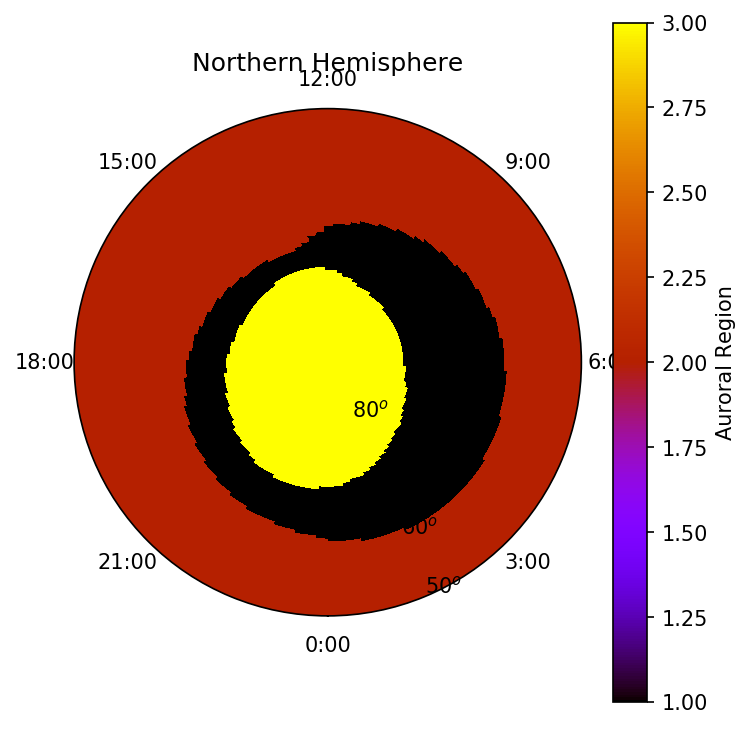

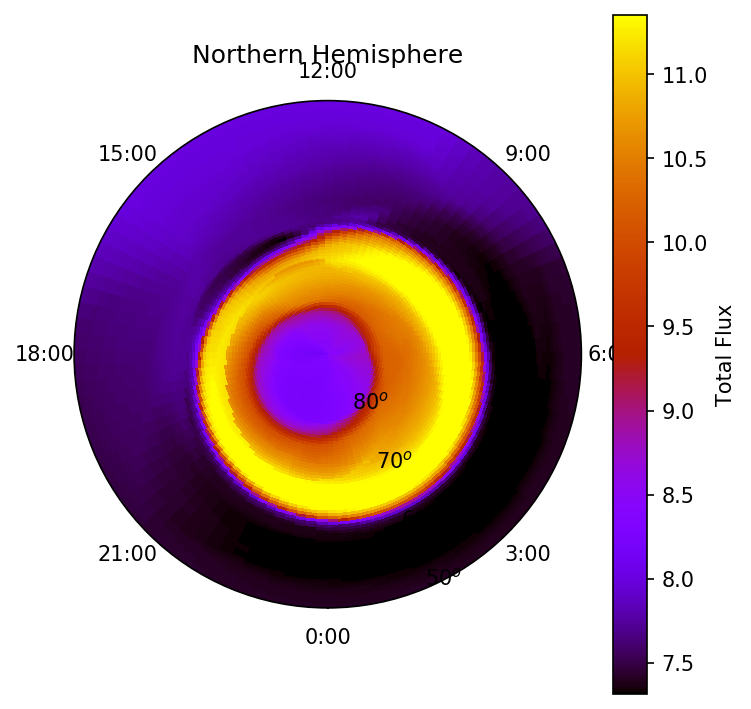

In [101]:
os.system('source ~/Downloads/cdf37_1-dist/src/definitions/definitions.K')
os.environ["CDF_LIB"] = '/home/jackalak/Downloads/cdf37_1-dist/lib'
from ovationpyme.ovation_plotting import latlt2polar,polar2dial,pcolor_flux
%matplotlib inline




f = plt.figure(figsize=(12,6),dpi=150)
axN = f.add_subplot(121,projection='polar')
pcolor_kwargs = {'cmap':'gnuplot'}
mappableN = pcolor_flux(axN,mlatgridN,mltgridN, model_input[:,:,148] ,'N',**pcolor_kwargs)
f.colorbar(mappableN,ax=axN,label='Auroral Region')
axN.set_title('Northern Hemisphere')
polar2dial(axN)
f.suptitle('')
plt.show()

f = plt.figure(figsize=(12,6),dpi=150)
axN = f.add_subplot(121,projection='polar')
pcolor_kwargs = {'cmap':'gnuplot'}
mappableN = pcolor_flux(axN,mlatgridN,mltgridN,flux,'N',**pcolor_kwargs)
f.colorbar(mappableN,ax=axN,label='Total Flux')
axN.set_title('Northern Hemisphere')
polar2dial(axN)
f.suptitle('')
plt.show()

